In [1]:
%matplotlib inline
import hashlib
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size


D = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

N = 1024
Z = 8

MAX_ITER = 1000

def hamming(x_k, x_l):
    return np.mean(x_k != x_l)

In [2]:
class Encoder(object):
    
    
    def __init__(self, seed, d, n, z):
        self.seed = seed
        
        self.n = n
        self.z = z
        
        # sample basis and mask function aux var
        np.random.seed(seed)
        self.xs = {s: np.random.randint(0, z, n) for s in d}
        
        self.seed_offset = np.random.randint(0, 2**32-1)
    
    
    def veil(self, xs):
        # get unique RNG seed from all xs
        str_repr = ''.join([''.join(x.astype(str)) for x in xs])
        rng_seed = int(hashlib.sha256(str_repr.encode('utf-8')).hexdigest(), 16)  % 10**9
        
        np.random.seed((rng_seed + self.seed_offset)%(2**32))
        
        return np.random.rand(len(xs[0]))
    
    
    def weave(self, xs):
        assert len(xs) >= 2
        
        veil = self.veil(xs)
        u = xs[0].copy()
        
        for ctr, x in enumerate(xs[1:], 1):
            mask = (ctr/len(xs) <= veil) & (veil < (ctr+1)/len(xs))
            u[mask] = x[mask]
        return u
    
    
    def encode(self, jctns):
        
        xs_tmp = {}
        
        for jctn in jctns:
            
            if len(jctn) == 1:
                xs_tmp[jctn] = self.xs[jctn[0]]
            else:
                xs_jctn = []
                for s in jctn:

                    if s in self.xs:
                        xs_jctn.append(self.xs[s])

                    elif s in xs_tmp:
                        xs_jctn.append(xs_tmp[s])

                xs_tmp[jctn] = self.weave(xs_jctn)
            
        return xs_tmp[jctns[-1]]

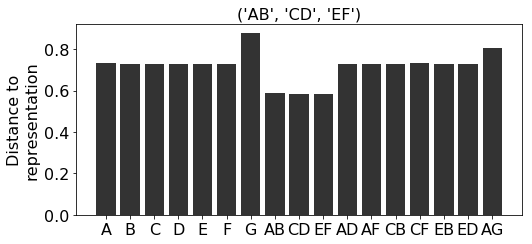

In [3]:
tree = ['AB', 'CD', 'EF', ('AB', 'CD', 'EF')]
compare = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'AB', 'CD', 'EF', 'AD', 'AF', 'CB', 'CF', 'EB', 'ED', 'AG']
n_trial = 100

dsts = np.nan * np.zeros((n_trial, len(compare)))

for seed in range(n_trial):
    encoder = Encoder(seed, D, N, Z)
    x = encoder.encode(tree)

    for c_ctr, compare_ in enumerate(compare):        
        dsts[seed, c_ctr] = hamming(x, encoder.encode([compare_]))
        
fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), tight_layout=True)

ax.bar(np.arange(len(compare)), dsts.mean(0), color='k', alpha=.8)
ax.set_xticks(np.arange(len(compare)))
ax.set_xticklabels(compare)
ax.set_ylabel('Distance to\nrepresentation')
ax.set_title(tree[-1])

set_font_size(ax, 16)

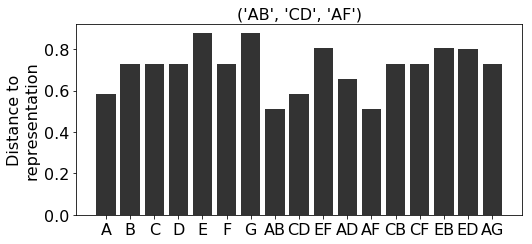

In [4]:
tree = ['AB', 'CD', 'AF', ('AB', 'CD', 'AF')]
compare = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'AB', 'CD', 'EF', 'AD', 'AF', 'CB', 'CF', 'EB', 'ED', 'AG']
n_trial = 100

dsts = np.nan * np.zeros((n_trial, len(compare)))

for seed in range(n_trial):
    encoder = Encoder(seed, D, N, Z)
    x = encoder.encode(tree)

    for c_ctr, compare_ in enumerate(compare):        
        dsts[seed, c_ctr] = hamming(x, encoder.encode([compare_]))
        
fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), tight_layout=True)

ax.bar(np.arange(len(compare)), dsts.mean(0), color='k', alpha=.8)
ax.set_xticks(np.arange(len(compare)))
ax.set_xticklabels(compare)
ax.set_ylabel('Distance to\nrepresentation')
ax.set_title(tree[-1])

set_font_size(ax, 16)